# Multi-Model Comparative Analysis

## Comprehensive comparison of AI models vs each other and vs human raters

### Models Analyzed:
1. **GPT-4o** (OpenAI's flagship model)
2. **GPT-3.5-turbo** (OpenAI's fast model)
3. **Llama-3.1-8B** (Open source model)
4. **Human Recruiter** (Professional recruiter)
5. **Service Owner** (Domain expert)

### Analysis Types:
- **Model-to-Model:** GPT-4o vs GPT-3.5 vs Llama
- **Model-to-Human:** Each AI vs Recruiter and Service Owner
- **Performance:** Cost, speed, quality tradeoffs

### Outputs:
- 10 pairwise comparisons (5 raters × 4 pairs each)
- Model performance dashboard
- Deployment recommendations

## 1. Setup & Data Loading

In [2]:
# Install required packages
!pip install pandas numpy scipy matplotlib seaborn pingouin scikit-learn -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr, wilcoxon
import pingouin as pg
from sklearn.metrics import confusion_matrix
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [4]:
# Configure file paths for all raters
# UPDATE THESE PATHS TO YOUR FILES!

# Load data
FILE_PATHS = {
    'gpt4o': '/Users/shreya_sudan/Desktop/ServiceAgent/CleanAgent/metaPromptOpt/data/gptResults/gpt-4o/final_gpt-4o_20251104-225703.csv',
    'gpt35': '/Users/shreya_sudan/Desktop/ServiceAgent/CleanAgent/metaPromptOpt/data/gptResults/gpt-3.5-turbo/final_gpt-3.5-turbo_20251104-231014.csv',
    'llama': '/Users/shreya_sudan/Desktop/ServiceAgent/CleanAgent/metaPromptOpt/data/metaResults/final_meta-llama_Llama-3.1-8B-Instruct_novita_20251104-234821.csv',
    'recruiter': '/Users/shreya_sudan/Desktop/ServiceAgent/CleanAgent/metaPromptOpt/data/candidates_v2_recruiter_graded.csv',
    'owner': '/Users/shreya_sudan/Desktop/ServiceAgent/CleanAgent/metaPromptOpt/data/candidates_v2_service_owner_graded.csv'
}

# Define which raters are AI vs human
AI_MODELS = ['gpt4o', 'gpt35', 'llama']
HUMAN_RATERS = ['recruiter', 'owner']
ALL_RATERS = AI_MODELS + HUMAN_RATERS

# Metric definitions
METRICS = ["cognitive_ability", "experience", "problem_solving", 
           "reliability", "professionalism", "communication"]
SCORE_COLS = [f"{m}_score" for m in METRICS]

print("Configuration loaded:")
print(f"  AI Models: {AI_MODELS}")
print(f"  Human Raters: {HUMAN_RATERS}")
print(f"  Metrics: {len(METRICS)}")

Configuration loaded:
  AI Models: ['gpt4o', 'gpt35', 'llama']
  Human Raters: ['recruiter', 'owner']
  Metrics: 6


In [5]:
# Load all data
print("Loading data...")

dataframes = {}

# Load AI model scores (already in correct format)
for model in AI_MODELS:
    if model in FILE_PATHS:
        try:
            df = pd.read_csv(FILE_PATHS[model])
            dataframes[model] = df
            print(f"  ✓ {model}: {len(df)} interviews")
        except FileNotFoundError:
            print(f"  ⚠️ {model}: File not found - will be excluded from analysis")
        except Exception as e:
            print(f"  ❌ {model}: Error loading - {e}")

# Load human scores (need parsing)
METRICS_HUMAN = ["Cognitive ability", "Experience", "Problem Solving", 
                 "Reliability", "Professionalism", "Communication"]

def extract_score_and_justification(df, metric_cols):
    """Extract numeric scores from human rating format."""
    out = df.copy()
    for metric in metric_cols:
        base = metric.lower().replace(" ", "_")
        score_col = f"{base}_score"
        just_col = f"{base}_justification"
        if metric in df.columns:
            out[score_col] = df[metric].str.extract(r'(\d+)').astype(float)
            out[just_col] = df[metric].str.replace(r'^\s*\d+\s*[–-]\s*', '', regex=True).str.strip()
    return out

for rater in HUMAN_RATERS:
    if rater in FILE_PATHS:
        try:
            df = pd.read_csv(FILE_PATHS[rater])
            df = extract_score_and_justification(df, METRICS_HUMAN)
            dataframes[rater] = df
            print(f"  ✓ {rater}: {len(df)} interviews")
        except FileNotFoundError:
            print(f"  ⚠️ {rater}: File not found")
        except Exception as e:
            print(f"  ❌ {rater}: Error loading - {e}")

print(f"\n✓ Loaded {len(dataframes)} raters successfully")

Loading data...
  ✓ gpt4o: 50 interviews
  ✓ gpt35: 50 interviews
  ✓ llama: 49 interviews
  ✓ recruiter: 50 interviews
  ✓ owner: 50 interviews

✓ Loaded 5 raters successfully


In [6]:
# Create unified comparison dataframe
def create_master_comparison_df(dataframes_dict):
    """Merge all rater scores into one dataframe."""
    
    # Start with first available rater
    first_rater = list(dataframes_dict.keys())[0]
    master_df = dataframes_dict[first_rater][['interview_id'] + SCORE_COLS].copy()
    master_df.columns = ['interview_id'] + [f"{c}_{first_rater}" for c in SCORE_COLS]
    
    # Merge remaining raters
    for rater in list(dataframes_dict.keys())[1:]:
        df = dataframes_dict[rater][['interview_id'] + SCORE_COLS].copy()
        df.columns = ['interview_id'] + [f"{c}_{rater}" for c in SCORE_COLS]
        master_df = master_df.merge(df, on='interview_id', how='outer')
    
    return master_df

master_df = create_master_comparison_df(dataframes)

print(f"✓ Created master comparison dataframe")
print(f"  Total interviews: {len(master_df)}")
print(f"  Total columns: {len(master_df.columns)}")
print(f"\nAvailable comparisons by interview:")

for rater in dataframes.keys():
    col = f"{SCORE_COLS[0]}_{rater}"
    count = master_df[col].notna().sum()
    print(f"  {rater}: {count} interviews")

display(master_df.head())

✓ Created master comparison dataframe
  Total interviews: 50
  Total columns: 31

Available comparisons by interview:
  gpt4o: 50 interviews
  gpt35: 50 interviews
  llama: 49 interviews
  recruiter: 50 interviews
  owner: 50 interviews


,interview_id,cognitive_ability_score_gpt4o,experience_score_gpt4o,problem_solving_score_gpt4o,reliability_score_gpt4o,professionalism_score_gpt4o,communication_score_gpt4o,cognitive_ability_score_gpt35,experience_score_gpt35,problem_solving_score_gpt35,...,problem_solving_score_recruiter,reliability_score_recruiter,professionalism_score_recruiter,communication_score_recruiter,cognitive_ability_score_owner,experience_score_owner,problem_solving_score_owner,reliability_score_owner,professionalism_score_owner,communication_score_owner
0,intv_0001,9,8,8,8,8,8,8,7,7,...,6.0,5.0,6.0,4.0,5.0,6.0,5.0,4.0,5.0,4.0
1,intv_0002,8,8,8,8,7,8,8,7,7,...,6.0,5.0,6.0,4.0,7.0,8.0,7.0,6.0,7.0,6.0
2,intv_0003,8,8,8,7,7,7,8,7,7,...,6.0,5.0,6.0,4.0,7.0,8.0,7.0,6.0,7.0,6.0
3,intv_0004,8,8,8,8,8,7,8,7,7,...,8.0,7.0,8.0,6.0,5.0,6.0,5.0,4.0,5.0,4.0
4,intv_0005,7,4,6,6,7,7,8,7,7,...,6.0,5.0,6.0,4.0,5.0,6.0,5.0,4.0,5.0,4.0


## 2. Inter-Rater Reliability Analysis

In [7]:
def calculate_icc_pair(df, metric, rater1, rater2):
    """Calculate ICC for a pair of raters on one metric."""
    col1 = f"{metric}_score_{rater1}"
    col2 = f"{metric}_score_{rater2}"
    
    # Prepare data
    data = []
    for idx, row in df.iterrows():
        if pd.notna(row[col1]) and pd.notna(row[col2]):
            data.append({'interview': idx, 'rater': 'rater1', 'score': row[col1]})
            data.append({'interview': idx, 'rater': 'rater2', 'score': row[col2]})
    
    if len(data) < 4:
        return np.nan, np.nan, np.nan, 0
    
    df_long = pd.DataFrame(data)
    n = len(data) // 2
    
    try:
        icc_result = pg.intraclass_corr(data=df_long, targets='interview', 
                                        raters='rater', ratings='score')
        icc_row = icc_result[icc_result['Type'] == 'ICC2']
        if len(icc_row) > 0:
            return (icc_row['ICC'].values[0], 
                   icc_row['CI95%'].values[0][0], 
                   icc_row['CI95%'].values[0][1],
                   n)
    except:
        pass
    
    return np.nan, np.nan, np.nan, n

def calculate_agreement_rate(df, metric, rater1, rater2, threshold=1):
    """Calculate % agreement within threshold."""
    col1 = f"{metric}_score_{rater1}"
    col2 = f"{metric}_score_{rater2}"
    
    mask = df[col1].notna() & df[col2].notna()
    if mask.sum() == 0:
        return np.nan
    
    diffs = (df.loc[mask, col1] - df.loc[mask, col2]).abs()
    return (diffs <= threshold).sum() / len(diffs) * 100

# Calculate all pairwise comparisons
print("=" * 80)
print("COMPREHENSIVE INTER-RATER RELIABILITY MATRIX")
print("=" * 80)

reliability_results = []

raters = list(dataframes.keys())
for i, rater1 in enumerate(raters):
    for j, rater2 in enumerate(raters):
        if j > i:  # Only upper triangle
            print(f"\n{rater1.upper()} vs {rater2.upper()}:")
            print("-" * 80)
            
            for metric in METRICS:
                icc, icc_low, icc_high, n = calculate_icc_pair(master_df, metric, rater1, rater2)
                agree_exact = calculate_agreement_rate(master_df, metric, rater1, rater2, 0)
                agree_1 = calculate_agreement_rate(master_df, metric, rater1, rater2, 1)
                
                if not np.isnan(icc):
                    print(f"  {metric.replace('_', ' ').title():<25} "
                          f"ICC={icc:.3f} [{icc_low:.3f}-{icc_high:.3f}]  "
                          f"Agree(±1)={agree_1:.1f}%  n={n}")
                
                reliability_results.append({
                    'rater1': rater1,
                    'rater2': rater2,
                    'metric': metric,
                    'icc': icc,
                    'icc_low': icc_low,
                    'icc_high': icc_high,
                    'agree_exact': agree_exact,
                    'agree_within1': agree_1,
                    'n': n
                })

reliability_df = pd.DataFrame(reliability_results)
print("\n" + "=" * 80)

COMPREHENSIVE INTER-RATER RELIABILITY MATRIX

GPT4O vs GPT35:
--------------------------------------------------------------------------------
  Cognitive Ability         ICC=-0.000 [-0.250-0.260]  Agree(±1)=92.0%  n=50
  Experience                ICC=0.000 [-0.280-0.280]  Agree(±1)=82.0%  n=50
  Problem Solving           ICC=-0.000 [-0.260-0.270]  Agree(±1)=92.0%  n=50
  Reliability               ICC=0.000 [-0.190-0.220]  Agree(±1)=100.0%  n=50
  Professionalism           ICC=0.000 [-0.040-0.070]  Agree(±1)=82.0%  n=50
  Communication             ICC=-0.000 [-0.030-0.050]  Agree(±1)=84.0%  n=50

GPT4O vs LLAMA:
--------------------------------------------------------------------------------
  Cognitive Ability         ICC=0.680 [0.500-0.810]  Agree(±1)=98.0%  n=49
  Experience                ICC=0.809 [0.570-0.910]  Agree(±1)=89.8%  n=49
  Problem Solving           ICC=0.607 [0.370-0.760]  Agree(±1)=93.9%  n=49
  Reliability               ICC=0.243 [-0.070-0.520]  Agree(±1)=91.8%  n=4

## 3. Model-to-Model Comparison (AI vs AI)

MODEL-TO-MODEL AGREEMENT SUMMARY

GPT4O vs GPT35:
  Average ICC: -0.000
  Average Agreement (±1): 88.7%

  Per-metric ICC:
    Cognitive Ability         -0.000
    Experience                0.000
    Problem Solving           -0.000
    Reliability               0.000
    Professionalism           0.000
    Communication             -0.000

GPT4O vs LLAMA:
  Average ICC: 0.387
  Average Agreement (±1): 91.5%

  Per-metric ICC:
    Cognitive Ability         0.680
    Experience                0.809
    Problem Solving           0.607
    Reliability               0.243
    Professionalism           -0.004
    Communication             -0.015

GPT35 vs LLAMA:
  Average ICC: -0.000
  Average Agreement (±1): 62.2%

  Per-metric ICC:
    Cognitive Ability         -0.000
    Experience                0.000
    Problem Solving           0.000
    Reliability               -0.000
    Professionalism           0.000
    Communication             -0.000



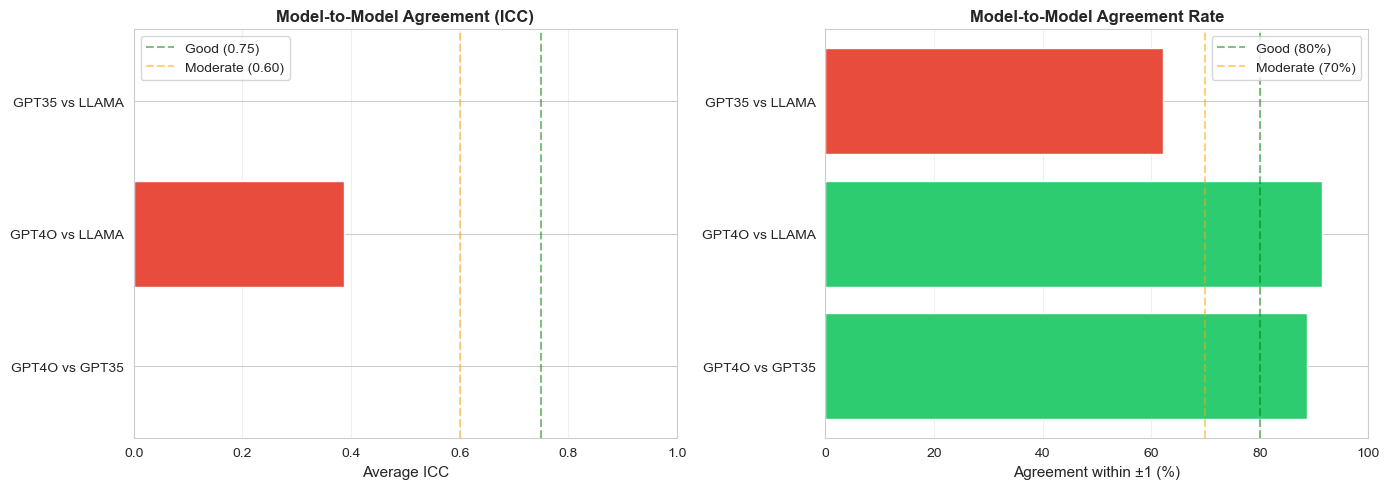

In [8]:
# Extract AI-to-AI comparisons
ai_comparisons = reliability_df[
    reliability_df['rater1'].isin(AI_MODELS) & 
    reliability_df['rater2'].isin(AI_MODELS)
]

print("=" * 80)
print("MODEL-TO-MODEL AGREEMENT SUMMARY")
print("=" * 80)

# Calculate average ICC for each model pair
model_pairs = []
for i, m1 in enumerate(AI_MODELS):
    for j, m2 in enumerate(AI_MODELS):
        if j > i:
            subset = ai_comparisons[
                ((ai_comparisons['rater1'] == m1) & (ai_comparisons['rater2'] == m2)) |
                ((ai_comparisons['rater1'] == m2) & (ai_comparisons['rater2'] == m1))
            ]
            if len(subset) > 0:
                avg_icc = subset['icc'].mean()
                avg_agree = subset['agree_within1'].mean()
                model_pairs.append({
                    'pair': f"{m1.upper()} vs {m2.upper()}",
                    'avg_icc': avg_icc,
                    'avg_agreement': avg_agree
                })
                print(f"\n{m1.upper()} vs {m2.upper()}:")
                print(f"  Average ICC: {avg_icc:.3f}")
                print(f"  Average Agreement (±1): {avg_agree:.1f}%")
                
                # Show per-metric breakdown
                print("\n  Per-metric ICC:")
                for _, row in subset.iterrows():
                    print(f"    {row['metric'].replace('_', ' ').title():<25} {row['icc']:.3f}")

print("\n" + "=" * 80)

# Visualize model-to-model ICC
if len(model_pairs) > 0:
    model_pairs_df = pd.DataFrame(model_pairs)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # ICC comparison
    colors = ['#e74c3c' if icc < 0.6 else '#f39c12' if icc < 0.75 else '#2ecc71' 
              for icc in model_pairs_df['avg_icc']]
    ax1.barh(model_pairs_df['pair'], model_pairs_df['avg_icc'], color=colors)
    ax1.axvline(0.75, color='green', linestyle='--', alpha=0.5, label='Good (0.75)')
    ax1.axvline(0.60, color='orange', linestyle='--', alpha=0.5, label='Moderate (0.60)')
    ax1.set_xlabel('Average ICC', fontsize=11)
    ax1.set_title('Model-to-Model Agreement (ICC)', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.set_xlim(0, 1)
    ax1.grid(axis='x', alpha=0.3)
    
    # Agreement rate comparison
    colors2 = ['#e74c3c' if a < 70 else '#f39c12' if a < 80 else '#2ecc71' 
               for a in model_pairs_df['avg_agreement']]
    ax2.barh(model_pairs_df['pair'], model_pairs_df['avg_agreement'], color=colors2)
    ax2.axvline(80, color='green', linestyle='--', alpha=0.5, label='Good (80%)')
    ax2.axvline(70, color='orange', linestyle='--', alpha=0.5, label='Moderate (70%)')
    ax2.set_xlabel('Agreement within ±1 (%)', fontsize=11)
    ax2.set_title('Model-to-Model Agreement Rate', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.set_xlim(0, 100)
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 4. Model-to-Human Comparison (AI vs Human)

MODEL-TO-HUMAN AGREEMENT SUMMARY

GPT4O vs HUMAN RATERS:
--------------------------------------------------------------------------------

  vs RECRUITER:
    Average ICC: -0.015
    Average Agreement (±1): 49.0%
    Best metric: Experience (ICC=0.066)
    Worst metric: Professionalism (ICC=-0.111)

  vs OWNER:
    Average ICC: 0.047
    Average Agreement (±1): 30.7%
    Best metric: Experience (ICC=0.162)
    Worst metric: Professionalism (ICC=-0.001)

GPT35 vs HUMAN RATERS:
--------------------------------------------------------------------------------

  vs RECRUITER:
    Average ICC: 0.000
    Average Agreement (±1): 48.0%
    Best metric: Problem Solving (ICC=0.000)
    Worst metric: Professionalism (ICC=-0.000)

  vs OWNER:
    Average ICC: 0.000
    Average Agreement (±1): 50.7%
    Best metric: Experience (ICC=0.000)
    Worst metric: Cognitive Ability (ICC=-0.000)

LLAMA vs HUMAN RATERS:
--------------------------------------------------------------------------------

  vs RE

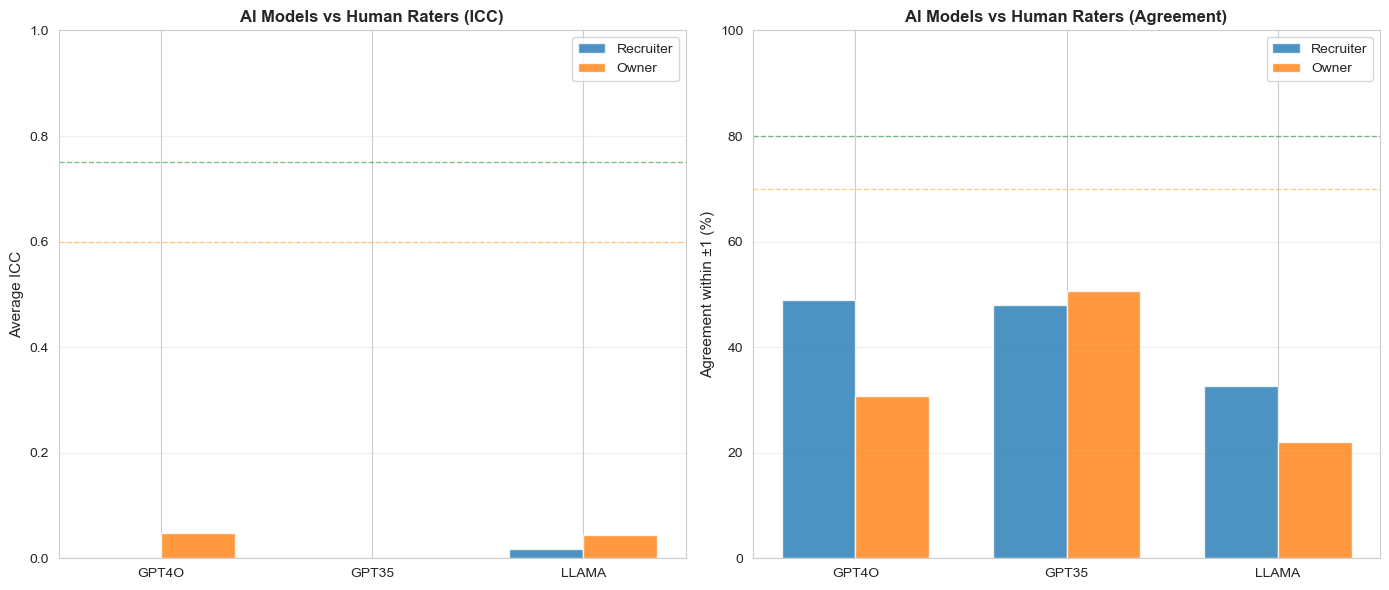

In [9]:
# Extract AI-to-Human comparisons
ai_human_comparisons = reliability_df[
    ((reliability_df['rater1'].isin(AI_MODELS) & reliability_df['rater2'].isin(HUMAN_RATERS)) |
     (reliability_df['rater1'].isin(HUMAN_RATERS) & reliability_df['rater2'].isin(AI_MODELS)))
]

print("=" * 80)
print("MODEL-TO-HUMAN AGREEMENT SUMMARY")
print("=" * 80)

# Calculate average ICC for each AI model vs humans
model_human_results = []

for ai_model in AI_MODELS:
    if ai_model in dataframes:
        print(f"\n{ai_model.upper()} vs HUMAN RATERS:")
        print("-" * 80)
        
        for human in HUMAN_RATERS:
            if human in dataframes:
                subset = ai_human_comparisons[
                    ((ai_human_comparisons['rater1'] == ai_model) & (ai_human_comparisons['rater2'] == human)) |
                    ((ai_human_comparisons['rater1'] == human) & (ai_human_comparisons['rater2'] == ai_model))
                ]
                
                if len(subset) > 0:
                    avg_icc = subset['icc'].mean()
                    avg_agree = subset['agree_within1'].mean()
                    
                    print(f"\n  vs {human.upper()}:")
                    print(f"    Average ICC: {avg_icc:.3f}")
                    print(f"    Average Agreement (±1): {avg_agree:.1f}%")
                    
                    model_human_results.append({
                        'ai_model': ai_model,
                        'human': human,
                        'avg_icc': avg_icc,
                        'avg_agreement': avg_agree
                    })
                    
                    # Best and worst metrics
                    best_metric = subset.loc[subset['icc'].idxmax()]
                    worst_metric = subset.loc[subset['icc'].idxmin()]
                    print(f"    Best metric: {best_metric['metric'].replace('_', ' ').title()} (ICC={best_metric['icc']:.3f})")
                    print(f"    Worst metric: {worst_metric['metric'].replace('_', ' ').title()} (ICC={worst_metric['icc']:.3f})")

print("\n" + "=" * 80)

# Visualize model-to-human comparison
if len(model_human_results) > 0:
    mh_df = pd.DataFrame(model_human_results)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Prepare data for grouped bar chart
    ai_models_present = mh_df['ai_model'].unique()
    human_raters_present = mh_df['human'].unique()
    
    x = np.arange(len(ai_models_present))
    width = 0.35
    
    # ICC plot
    for i, human in enumerate(human_raters_present):
        data = [mh_df[(mh_df['ai_model'] == ai) & (mh_df['human'] == human)]['avg_icc'].values[0]
                if len(mh_df[(mh_df['ai_model'] == ai) & (mh_df['human'] == human)]) > 0 else 0
                for ai in ai_models_present]
        axes[0].bar(x + i*width - width/2, data, width, 
                   label=human.title(), alpha=0.8)
    
    axes[0].axhline(0.75, color='green', linestyle='--', alpha=0.5, linewidth=1)
    axes[0].axhline(0.60, color='orange', linestyle='--', alpha=0.5, linewidth=1)
    axes[0].set_ylabel('Average ICC', fontsize=11)
    axes[0].set_title('AI Models vs Human Raters (ICC)', fontsize=12, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([ai.upper() for ai in ai_models_present])
    axes[0].legend()
    axes[0].set_ylim(0, 1)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Agreement rate plot
    for i, human in enumerate(human_raters_present):
        data = [mh_df[(mh_df['ai_model'] == ai) & (mh_df['human'] == human)]['avg_agreement'].values[0]
                if len(mh_df[(mh_df['ai_model'] == ai) & (mh_df['human'] == human)]) > 0 else 0
                for ai in ai_models_present]
        axes[1].bar(x + i*width - width/2, data, width, 
                   label=human.title(), alpha=0.8)
    
    axes[1].axhline(80, color='green', linestyle='--', alpha=0.5, linewidth=1)
    axes[1].axhline(70, color='orange', linestyle='--', alpha=0.5, linewidth=1)
    axes[1].set_ylabel('Agreement within ±1 (%)', fontsize=11)
    axes[1].set_title('AI Models vs Human Raters (Agreement)', fontsize=12, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([ai.upper() for ai in ai_models_present])
    axes[1].legend()
    axes[1].set_ylim(0, 100)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Comprehensive ICC Heatmap (All Comparisons)

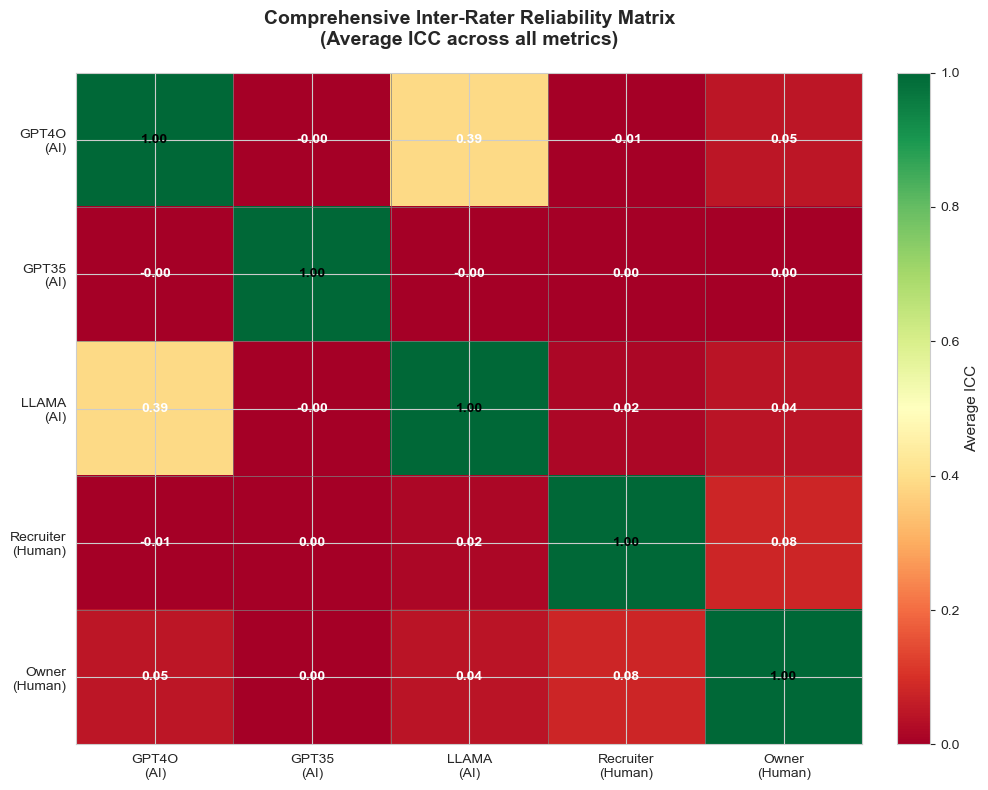


ICC Interpretation:
  🟢 Green (>0.75): Good to excellent agreement
  🟡 Yellow (0.60-0.75): Moderate agreement
  🟠 Orange (0.50-0.60): Fair agreement
  🔴 Red (<0.50): Poor agreement


In [10]:
# Create ICC matrix for all rater pairs
raters_list = list(dataframes.keys())
n_raters = len(raters_list)

icc_matrix = np.zeros((n_raters, n_raters))
icc_matrix[:] = np.nan

for i, rater1 in enumerate(raters_list):
    for j, rater2 in enumerate(raters_list):
        if i == j:
            icc_matrix[i, j] = 1.0  # Perfect agreement with self
        else:
            subset = reliability_df[
                ((reliability_df['rater1'] == rater1) & (reliability_df['rater2'] == rater2)) |
                ((reliability_df['rater1'] == rater2) & (reliability_df['rater2'] == rater1))
            ]
            if len(subset) > 0:
                icc_matrix[i, j] = subset['icc'].mean()

# Plot comprehensive heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Create labels with categories
labels = []
for r in raters_list:
    if r in AI_MODELS:
        labels.append(f"{r.upper()}\n(AI)")
    else:
        labels.append(f"{r.title()}\n(Human)")

im = ax.imshow(icc_matrix, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')

# Add text annotations
for i in range(n_raters):
    for j in range(n_raters):
        if not np.isnan(icc_matrix[i, j]):
            text = ax.text(j, i, f'{icc_matrix[i, j]:.2f}',
                         ha="center", va="center",
                         color="white" if icc_matrix[i, j] < 0.5 else "black",
                         fontsize=10, fontweight='bold')

# Labels and colorbar
ax.set_xticks(np.arange(n_raters))
ax.set_yticks(np.arange(n_raters))
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticklabels(labels, fontsize=10)

plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Average ICC', fontsize=11)

ax.set_title('Comprehensive Inter-Rater Reliability Matrix\n(Average ICC across all metrics)', 
            fontsize=14, fontweight='bold', pad=20)

# Add grid
ax.set_xticks(np.arange(n_raters)-.5, minor=True)
ax.set_yticks(np.arange(n_raters)-.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\nICC Interpretation:")
print("  🟢 Green (>0.75): Good to excellent agreement")
print("  🟡 Yellow (0.60-0.75): Moderate agreement")
print("  🟠 Orange (0.50-0.60): Fair agreement")
print("  🔴 Red (<0.50): Poor agreement")

## 6. Model Performance Dashboard

MODEL PERFORMANCE DASHBOARD

Model Performance Comparison:
--------------------------------------------------------------------------------
Model                Avg Score    ICC (Human)     Agreement    Latency      Cost
--------------------------------------------------------------------------------
GPT-4o               7.29±0.91    0.016           39.8%        7926ms       $825.00
GPT-3.5-turbo        6.83±0.69    0.000           49.3%        3908ms       $142.50
Llama-3.1-8B         7.85±0.82    0.031           27.4%        7649ms       $24.00
--------------------------------------------------------------------------------


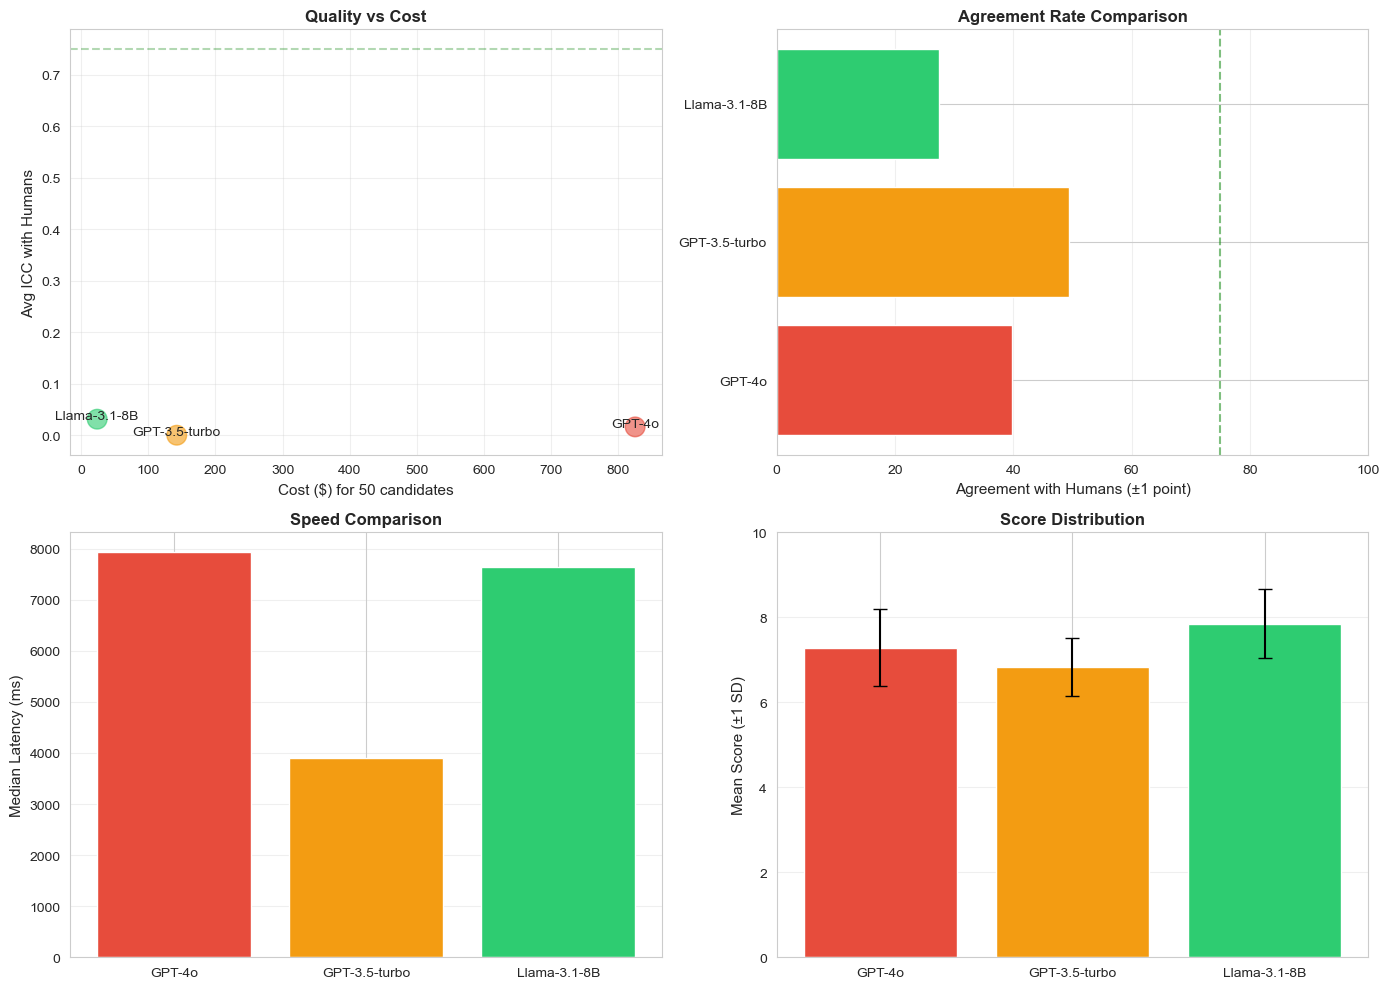

In [11]:
# Create performance comparison for AI models
print("=" * 80)
print("MODEL PERFORMANCE DASHBOARD")
print("=" * 80)

performance_data = []

# Typical costs (update as needed)
MODEL_COSTS = {
    'gpt4o': {'cost_per_1k_input': 2.50/1000, 'cost_per_1k_output': 10.00/1000, 'label': 'GPT-4o'},
    'gpt35': {'cost_per_1k_input': 0.50/1000, 'cost_per_1k_output': 1.50/1000, 'label': 'GPT-3.5-turbo'},
    'llama': {'cost_per_1k_input': 0.10/1000, 'cost_per_1k_output': 0.20/1000, 'label': 'Llama-3.1-8B'}
}

for ai_model in AI_MODELS:
    if ai_model in dataframes:
        df = dataframes[ai_model]
        
        # Score statistics
        score_cols_model = [f"{m}_score" for m in METRICS if f"{m}_score" in df.columns]
        if score_cols_model:
            scores = df[score_cols_model].values.flatten()
            scores = scores[~np.isnan(scores)]
            
            mean_score = scores.mean()
            std_score = scores.std()
        else:
            mean_score = np.nan
            std_score = np.nan
        
        # Agreement with humans
        human_agreement_icc = []
        human_agreement_rate = []
        for human in HUMAN_RATERS:
            if human in dataframes:
                subset = reliability_df[
                    ((reliability_df['rater1'] == ai_model) & (reliability_df['rater2'] == human)) |
                    ((reliability_df['rater1'] == human) & (reliability_df['rater2'] == ai_model))
                ]
                if len(subset) > 0:
                    human_agreement_icc.append(subset['icc'].mean())
                    human_agreement_rate.append(subset['agree_within1'].mean())
        
        avg_human_icc = np.mean(human_agreement_icc) if human_agreement_icc else np.nan
        avg_human_agree = np.mean(human_agreement_rate) if human_agreement_rate else np.nan
        
        # Latency (if available)
        latency_cols = [c for c in df.columns if 'latency' in c.lower()]
        if latency_cols:
            median_latency = df[latency_cols[0]].median()
        else:
            median_latency = np.nan
        
        # Estimated cost (rough estimate for 50 candidates, K=3)
        if ai_model in MODEL_COSTS:
            # Rough estimate: 1000 tokens input + 300 tokens output per scoring run
            # 50 candidates * 3 runs * (1000 input + 300 output)
            est_cost = (50 * 3 * 1000 * MODEL_COSTS[ai_model]['cost_per_1k_input'] +
                       50 * 3 * 300 * MODEL_COSTS[ai_model]['cost_per_1k_output'])
        else:
            est_cost = np.nan
        
        performance_data.append({
            'model': MODEL_COSTS.get(ai_model, {}).get('label', ai_model.upper()),
            'mean_score': mean_score,
            'std_score': std_score,
            'avg_icc_human': avg_human_icc,
            'avg_agree_human': avg_human_agree,
            'median_latency_ms': median_latency,
            'est_cost_50_candidates': est_cost
        })

perf_df = pd.DataFrame(performance_data)

# Display table
print("\nModel Performance Comparison:")
print("-" * 80)
print(f"{'Model':<20} {'Avg Score':<12} {'ICC (Human)':<15} {'Agreement':<12} {'Latency':<12} {'Cost'}")
print("-" * 80)
for _, row in perf_df.iterrows():
    print(f"{row['model']:<20} "
          f"{row['mean_score']:.2f}±{row['std_score']:.2f}    "
          f"{row['avg_icc_human']:.3f}           "
          f"{row['avg_agree_human']:.1f}%        "
          f"{row['median_latency_ms']:.0f}ms       "
          f"${row['est_cost_50_candidates']:.2f}")
print("-" * 80)

# Visualize performance tradeoffs
if len(perf_df) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. ICC vs Cost
    axes[0, 0].scatter(perf_df['est_cost_50_candidates'], perf_df['avg_icc_human'], 
                      s=200, alpha=0.6, c=['#e74c3c', '#f39c12', '#2ecc71'])
    for idx, row in perf_df.iterrows():
        axes[0, 0].annotate(row['model'], 
                          (row['est_cost_50_candidates'], row['avg_icc_human']),
                          fontsize=10, ha='center')
    axes[0, 0].axhline(0.75, color='green', linestyle='--', alpha=0.3)
    axes[0, 0].set_xlabel('Cost ($) for 50 candidates', fontsize=11)
    axes[0, 0].set_ylabel('Avg ICC with Humans', fontsize=11)
    axes[0, 0].set_title('Quality vs Cost', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Agreement Rate comparison
    axes[0, 1].barh(perf_df['model'], perf_df['avg_agree_human'],
                    color=['#e74c3c', '#f39c12', '#2ecc71'])
    axes[0, 1].axvline(75, color='green', linestyle='--', alpha=0.5)
    axes[0, 1].set_xlabel('Agreement with Humans (±1 point)', fontsize=11)
    axes[0, 1].set_title('Agreement Rate Comparison', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlim(0, 100)
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # 3. Latency comparison
    axes[1, 0].bar(perf_df['model'], perf_df['median_latency_ms'],
                   color=['#e74c3c', '#f39c12', '#2ecc71'])
    axes[1, 0].set_ylabel('Median Latency (ms)', fontsize=11)
    axes[1, 0].set_title('Speed Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. Score distribution
    axes[1, 1].bar(perf_df['model'], perf_df['mean_score'], 
                   yerr=perf_df['std_score'],
                   color=['#e74c3c', '#f39c12', '#2ecc71'],
                   capsize=5)
    axes[1, 1].set_ylabel('Mean Score (±1 SD)', fontsize=11)
    axes[1, 1].set_title('Score Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylim(0, 10)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)

## 7. Systematic Bias Analysis (All Models)

SYSTEMATIC BIAS ANALYSIS (RATER 2 - RATER 1)

GPT35 - GPT4O:
--------------------------------------------------------------------------------
  Cognitive Ability         Bias: +0.22  MAE: 0.34
  Experience                Bias: -0.10  MAE: 1.18
  Problem Solving           Bias: -0.24  MAE: 0.80
  Reliability               Bias: -0.42  MAE: 0.66
  Professionalism           Bias: -1.08  MAE: 1.08
  Communication             Bias: -1.10  MAE: 1.10

LLAMA - GPT4O:
--------------------------------------------------------------------------------
  Cognitive Ability         Bias: +0.08  MAE: 0.33
  Experience                Bias: +0.47  MAE: 0.51
  Problem Solving           Bias: +0.35  MAE: 0.55
  Reliability               Bias: +0.65  MAE: 0.65
  Professionalism           Bias: +0.71  MAE: 0.80
  Communication             Bias: +1.00  MAE: 1.00

RECRUITER - GPT4O:
--------------------------------------------------------------------------------
  Cognitive Ability         Bias: -2.90  MAE: 2.

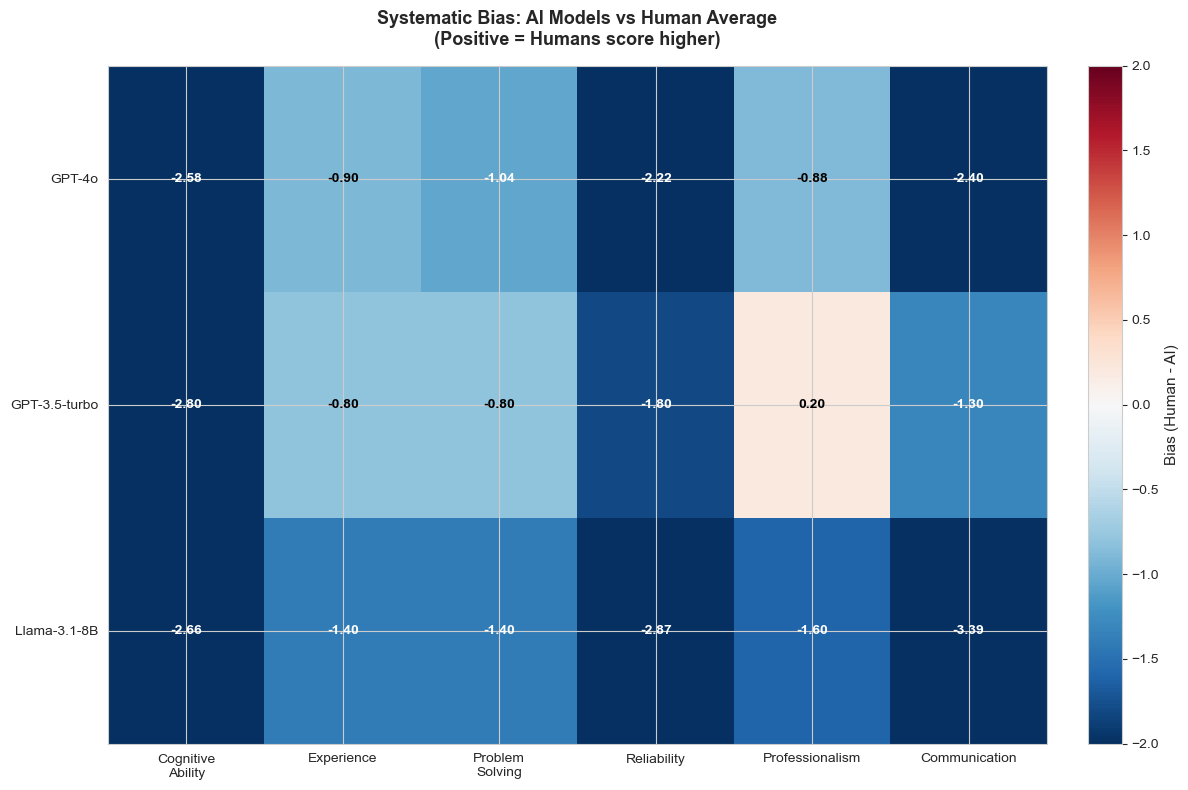


Bias Interpretation:
  🔴 Red (positive): Humans score higher than AI
  🔵 Blue (negative): AI scores higher than humans
  ⚪ White (near zero): Well-calibrated



In [12]:
# Calculate bias for all model pairs
print("=" * 80)
print("SYSTEMATIC BIAS ANALYSIS (RATER 2 - RATER 1)")
print("=" * 80)

bias_results = []

for i, rater1 in enumerate(raters_list):
    for j, rater2 in enumerate(raters_list):
        if j > i:
            print(f"\n{rater2.upper()} - {rater1.upper()}:")
            print("-" * 80)
            
            for metric in METRICS:
                col1 = f"{metric}_score_{rater1}"
                col2 = f"{metric}_score_{rater2}"
                
                mask = master_df[col1].notna() & master_df[col2].notna()
                if mask.sum() > 1:
                    bias = (master_df.loc[mask, col2] - master_df.loc[mask, col1]).mean()
                    mae = (master_df.loc[mask, col2] - master_df.loc[mask, col1]).abs().mean()
                    
                    print(f"  {metric.replace('_', ' ').title():<25} Bias: {bias:+.2f}  MAE: {mae:.2f}")
                    
                    bias_results.append({
                        'rater1': rater1,
                        'rater2': rater2,
                        'metric': metric,
                        'bias': bias,
                        'mae': mae
                    })

bias_df = pd.DataFrame(bias_results)

# Visualize bias patterns for AI models vs humans
ai_human_bias = bias_df[
    ((bias_df['rater1'].isin(AI_MODELS) & bias_df['rater2'].isin(HUMAN_RATERS)) |
     (bias_df['rater1'].isin(HUMAN_RATERS) & bias_df['rater2'].isin(AI_MODELS)))
]

if len(ai_human_bias) > 0:
    # Create a heatmap of bias
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Pivot for heatmap
    pivot_data = []
    for ai in AI_MODELS:
        if ai in dataframes:
            row_data = []
            for metric in METRICS:
                # Get average bias across both human raters
                biases = []
                for human in HUMAN_RATERS:
                    if human in dataframes:
                        b1 = bias_df[(bias_df['rater1'] == ai) & (bias_df['rater2'] == human) & (bias_df['metric'] == metric)]
                        b2 = bias_df[(bias_df['rater1'] == human) & (bias_df['rater2'] == ai) & (bias_df['metric'] == metric)]
                        if len(b1) > 0:
                            biases.append(b1['bias'].values[0])
                        elif len(b2) > 0:
                            biases.append(-b2['bias'].values[0])  # Flip sign
                if biases:
                    row_data.append(np.mean(biases))
                else:
                    row_data.append(0)
            pivot_data.append(row_data)
    
    pivot_array = np.array(pivot_data)
    
    im = ax.imshow(pivot_array, cmap='RdBu_r', vmin=-2, vmax=2, aspect='auto')
    
    # Annotations
    for i in range(len(pivot_array)):
        for j in range(len(METRICS)):
            text = ax.text(j, i, f'{pivot_array[i, j]:.2f}',
                         ha="center", va="center",
                         color="white" if abs(pivot_array[i, j]) > 1 else "black",
                         fontsize=10, fontweight='bold')
    
    ax.set_xticks(np.arange(len(METRICS)))
    ax.set_yticks(np.arange(len([ai for ai in AI_MODELS if ai in dataframes])))
    ax.set_xticklabels([m.replace('_', '\n').title() for m in METRICS], fontsize=10)
    ax.set_yticklabels([MODEL_COSTS.get(ai, {}).get('label', ai.upper()) 
                       for ai in AI_MODELS if ai in dataframes], fontsize=10)
    
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Bias (Human - AI)', fontsize=11)
    
    ax.set_title('Systematic Bias: AI Models vs Human Average\n(Positive = Humans score higher)', 
                fontsize=13, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.show()
    
    print("\nBias Interpretation:")
    print("  🔴 Red (positive): Humans score higher than AI")
    print("  🔵 Blue (negative): AI scores higher than humans")
    print("  ⚪ White (near zero): Well-calibrated")

print("\n" + "=" * 80)

## 8. Final Recommendations

In [13]:
print("=" * 80)
print("COMPREHENSIVE ANALYSIS SUMMARY & RECOMMENDATIONS")
print("=" * 80)

# 1. Model-to-Model Consistency
print("\n1. AI MODEL CONSISTENCY")
print("-" * 80)
if len(model_pairs_df) > 0:
    best_pair = model_pairs_df.loc[model_pairs_df['avg_icc'].idxmax()]
    print(f"Best model agreement: {best_pair['pair']} (ICC={best_pair['avg_icc']:.3f})")
    
    if best_pair['avg_icc'] > 0.85:
        print("  ✓ Models are highly consistent with each other")
    elif best_pair['avg_icc'] > 0.75:
        print("  ✓ Models show good consistency")
    else:
        print("  ⚠️ Models show significant variation - consider why")

# 2. Model-to-Human Agreement
print("\n2. AI vs HUMAN AGREEMENT")
print("-" * 80)
if len(model_human_results) > 0:
    mh_df = pd.DataFrame(model_human_results)
    for ai in AI_MODELS:
        if ai in dataframes:
            ai_results = mh_df[mh_df['ai_model'] == ai]
            if len(ai_results) > 0:
                avg_icc = ai_results['avg_icc'].mean()
                avg_agree = ai_results['avg_agreement'].mean()
                
                label = MODEL_COSTS.get(ai, {}).get('label', ai.upper())
                print(f"\n{label}:")
                print(f"  Average ICC: {avg_icc:.3f}")
                print(f"  Average Agreement: {avg_agree:.1f}%")
                
                if avg_icc > 0.75 and avg_agree > 75:
                    print(f"  ✓ {label} ready for production")
                elif avg_icc > 0.60 and avg_agree > 70:
                    print(f"  ⚠️ {label} suitable with human oversight")
                else:
                    print(f"  ❌ {label} needs calibration before deployment")

# 3. Model Selection Recommendation
print("\n3. MODEL SELECTION RECOMMENDATION")
print("-" * 80)

if len(perf_df) > 1:
    # Score models on quality, cost, and speed
    perf_df['quality_score'] = perf_df['avg_icc_human'] * 100
    perf_df['cost_score'] = (1 / (perf_df['est_cost_50_candidates'] + 0.01)) * 10
    perf_df['speed_score'] = (1 / (perf_df['median_latency_ms'] / 1000 + 0.01)) * 10
    
    # Overall score (weighted)
    perf_df['overall_score'] = (
        perf_df['quality_score'] * 0.50 +  # 50% weight on quality
        perf_df['cost_score'] * 0.30 +     # 30% weight on cost
        perf_df['speed_score'] * 0.20      # 20% weight on speed
    )
    
    best_model = perf_df.loc[perf_df['overall_score'].idxmax()]
    
    print(f"\n🏆 Recommended Model: {best_model['model']}")
    print(f"   Quality: {best_model['avg_icc_human']:.3f} ICC")
    print(f"   Cost: ${best_model['est_cost_50_candidates']:.2f} per 50 candidates")
    print(f"   Speed: {best_model['median_latency_ms']:.0f}ms median")
    
    print("\n📊 Model Rankings:")
    ranked = perf_df.sort_values('overall_score', ascending=False)
    for idx, (_, row) in enumerate(ranked.iterrows(), 1):
        print(f"   {idx}. {row['model']} (Overall Score: {row['overall_score']:.1f})")
    
    print("\n💡 Use Case Recommendations:")
    print("   • Production (Best Balance): ", end="")
    print(ranked.iloc[0]['model'])
    
    print("   • Cost-Sensitive: ", end="")
    print(perf_df.loc[perf_df['est_cost_50_candidates'].idxmin()]['model'])
    
    print("   • Quality-First: ", end="")
    print(perf_df.loc[perf_df['avg_icc_human'].idxmax()]['model'])
    
    print("   • Speed-Critical: ", end="")
    print(perf_df.loc[perf_df['median_latency_ms'].idxmin()]['model'])

# 4. Action Items
print("\n4. NEXT STEPS")
print("-" * 80)
print("1. Review high-disagreement cases for selected model")
print("2. Validate on fresh test set (recommend 100+ interviews)")
print("3. Set up monitoring for agreement rates over time")
print("4. Define human review triggers (e.g., confidence < threshold)")
print("5. Plan quarterly recalibration sessions")

print("\n" + "=" * 80)
print("END OF COMPREHENSIVE ANALYSIS")
print("=" * 80)

COMPREHENSIVE ANALYSIS SUMMARY & RECOMMENDATIONS

1. AI MODEL CONSISTENCY
--------------------------------------------------------------------------------
Best model agreement: GPT4O vs LLAMA (ICC=0.387)
  ⚠️ Models show significant variation - consider why

2. AI vs HUMAN AGREEMENT
--------------------------------------------------------------------------------

GPT-4o:
  Average ICC: 0.016
  Average Agreement: 39.8%
  ❌ GPT-4o needs calibration before deployment

GPT-3.5-turbo:
  Average ICC: 0.000
  Average Agreement: 49.3%
  ❌ GPT-3.5-turbo needs calibration before deployment

Llama-3.1-8B:
  Average ICC: 0.031
  Average Agreement: 27.4%
  ❌ Llama-3.1-8B needs calibration before deployment

3. MODEL SELECTION RECOMMENDATION
--------------------------------------------------------------------------------

🏆 Recommended Model: Llama-3.1-8B
   Quality: 0.031 ICC
   Cost: $24.00 per 50 candidates
   Speed: 7649ms median

📊 Model Rankings:
   1. Llama-3.1-8B (Overall Score: 1.9)
   2. G

## 9. Export Results

In [14]:
from datetime import datetime
import os

# Create output directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = "/Users/shreya_sudan/Desktop/ServiceAgent/CleanAgent/metaPromptOpt/data/multi_model_analysis"
os.makedirs(output_dir, exist_ok=True)

# Save all results
reliability_df.to_csv(f"{output_dir}/all_pairwise_reliability_{timestamp}.csv", index=False)
bias_df.to_csv(f"{output_dir}/all_pairwise_bias_{timestamp}.csv", index=False)
master_df.to_csv(f"{output_dir}/master_comparison_{timestamp}.csv", index=False)

if len(perf_df) > 0:
    perf_df.to_csv(f"{output_dir}/model_performance_{timestamp}.csv", index=False)

if len(model_pairs_df) > 0:
    model_pairs_df.to_csv(f"{output_dir}/model_to_model_{timestamp}.csv", index=False)

if len(model_human_results) > 0:
    pd.DataFrame(model_human_results).to_csv(f"{output_dir}/model_to_human_{timestamp}.csv", index=False)

print(f"✓ All results saved to: {output_dir}")
print(f"\nFiles created:")
print(f"  - all_pairwise_reliability_{timestamp}.csv")
print(f"  - all_pairwise_bias_{timestamp}.csv")
print(f"  - master_comparison_{timestamp}.csv")
print(f"  - model_performance_{timestamp}.csv")
print(f"  - model_to_model_{timestamp}.csv")
print(f"  - model_to_human_{timestamp}.csv")

✓ All results saved to: /Users/shreya_sudan/Desktop/ServiceAgent/CleanAgent/metaPromptOpt/data/multi_model_analysis

Files created:
  - all_pairwise_reliability_20251104_162715.csv
  - all_pairwise_bias_20251104_162715.csv
  - master_comparison_20251104_162715.csv
  - model_performance_20251104_162715.csv
  - model_to_model_20251104_162715.csv
  - model_to_human_20251104_162715.csv
